# Load libraries

In [1]:
import sys
import glob
import warnings
warnings.filterwarnings("ignore")
from functools import reduce
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, learning_curve
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso, Ridge, ElasticNet, SGDRegressor, LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, LeaveOneOut, train_test_split, cross_val_score, \
                                    cross_validate,cross_val_predict, StratifiedKFold, KFold, GroupKFold, LeavePGroupsOut
from scipy.stats import pearsonr
#from adaptivesplit import ml
from sklearn.feature_selection import SelectKBest, f_regression, VarianceThreshold
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error, r2_score, explained_variance_score
import scipy.stats as stats
from statsmodels.graphics.gofplots import qqplot
#from PAINTeR import plot
from neurocombat_sklearn import CombatModel
from scipy.stats import normaltest
from mlxtend.evaluate import permutation_test

# Read freesurfer stats

In [2]:
def readFiles(feature_path, behavior_path,target_str, covar_list, subj_excl, study_ext):
    
    feature = pd.read_csv(feature_path, sep = '\t',index_col=0)
    for i in feature.index:
        feature.rename(index={i:i + study_ext},inplace=True)

    subj_excl_v1 = []
    
    if study_ext in {'_s1'} or study_ext in {'_s2'}:
        for i in subj_excl:
            subj_excl_v1.append('sub-' + i.zfill(3) + '_T1w' + study_ext)
    else:
        for i in subj_excl:
            subj_excl_v1.append('HC' + i.zfill(2) + study_ext)
    
    if not subj_excl:
        feature_v1 = feature
    else:
        feature_v1 = feature.drop(subj_excl_v1, axis=0)
    
    behavior = pd.read_csv(behavior_path)
    behavior.set_index('ID_EXT',inplace=True)
    
    target = behavior[target_str]
    df_merge = pd.merge(feature_v1, target, left_index=True, right_index=True, how= 'left') 
    
    age_cov = behavior[covar_list[0]]
    df_merge_age = pd.merge(df_merge, age_cov, left_index=True, right_index=True, how= 'left')   
    
    sex_cov = behavior[covar_list[1]]
    df_merge_age_sex = pd.merge(df_merge_age, sex_cov, left_index=True, right_index=True, how= 'left')   
    df_merge_age_sex.dropna(inplace=True)
    
    return df_merge_age_sex

# Models

In [3]:
class models_ml:
    def __init__(self, model_name, feature_size):
        self.model_name = model_name
        self.feature_size = feature_size
    
    def get_model(self):
        if self.model_name in {'modelLasso_nf'}:
            return self.modelLasso_nf()
        
        
    def modelLasso_nf(self):
        model = Pipeline([         
                          ('model_Lasso', Lasso(normalize=False,max_iter=100000))
                         ])
        p_grid = {
                  'model_Lasso__alpha':[1e-9, 1e-8, 1e-7, 1e-6,1e-5,1e-4,1e-3, 1e-2, 
                                        0.1, 1e+2, 1e+3, 10000,100000,1000000, 10000000, 100000000, 1000000000]} 
        return model, p_grid

# Study 1-3 data

In [4]:
s='s1_'
s_ = '_s1'
rpn = '_S1'
files = sorted(glob.glob("../data/data_unbias/s1*"))
appended_data = []
for i in files:
    print(i)
    temp = readFiles(feature_path = i, 
                           behavior_path = ('../data/data_unbias/RPN' + rpn + '_behavior_confounder_v1.csv'),
                           target_str = 'QST',
                           covar_list = ['Age','sex',''],
                           subj_excl = ['35'], 
                           study_ext = s_)
    appended_data.append(temp)

appended_data = pd.concat(appended_data, axis=1)
feature_s1 = appended_data
np_s1 = np.size(feature_s1,0)
feature_s1['batch'] = np.full((np_s1), 1, dtype=int)

s='_s2'
s_ = '_s2'
rpn = '_S2'
files = sorted(glob.glob("../data/data_unbias/s2*"))
appended_data = []
for i in files:
    print(i)
    temp = readFiles(feature_path = i, 
                           behavior_path = ('../data/data_unbias/RPN' + rpn + '_behavior_confounder_v1.csv'),
                           target_str = 'QST',
                           covar_list = ['Age','sex'],
                           subj_excl = [], 
                           study_ext = s_)
    appended_data.append(temp)

appended_data = pd.concat(appended_data, axis=1)
feature_s2 = appended_data
np_s2 = np.size(feature_s2,0)
feature_s2['batch'] = np.full((np_s2), 2, dtype=int)

s='_s3'
s_ = '_s3'
rpn = '_S3'
files = sorted(glob.glob("../data/data_unbias/s3*"))
appended_data = []
for i in files:
    print(i)
    temp = readFiles(feature_path = i, 
                           behavior_path = ('../data/data_unbias/RPN' + rpn + '_behavior_confounder_v1_dtvalues.csv'),
                           target_str = 'QST',
                           covar_list = ['Age','sex'],
                           subj_excl = [], 
                           study_ext = s_)
    appended_data.append(temp)

appended_data = pd.concat(appended_data, axis=1)
feature_s3 = appended_data
np_s3 = np.size(feature_s3,0)
feature_s3['batch'] = np.full((np_s3), 3, dtype=int)

../data/data_unbias\s1_lh_thickness.txt
../data/data_unbias\s1_lh_volume.txt
../data/data_unbias\s1_rh_thickness.txt
../data/data_unbias\s1_rh_volume.txt
../data/data_unbias\s1_subcortical_volume.txt
../data/data_unbias\s2_lh_thickness.txt
../data/data_unbias\s2_lh_volume.txt
../data/data_unbias\s2_rh_thickness.txt
../data/data_unbias\s2_rh_volume.txt
../data/data_unbias\s2_subcortical_volume.txt
../data/data_unbias\s3_lh_thickness.txt
../data/data_unbias\s3_lh_volume.txt
../data/data_unbias\s3_rh_thickness.txt
../data/data_unbias\s3_rh_volume.txt
../data/data_unbias\s3_subcortical_volume.txt


# Select cortical thickness stats

In [5]:
features = pd.concat([feature_s1, feature_s2, feature_s3], axis = 0)
X = features.drop(['eTIV','Age','sex','QST','batch','lh_MeanThickness_thickness',
                                 'rh_MeanThickness_thickness','3rd-Ventricle',
                                 '4th-Ventricle','5th-Ventricle','Left-Lateral-Ventricle',
                                 'Left-Inf-Lat-Vent','Left-Cerebellum-White-Matter','Left-vessel',
                                 'Left-choroid-plexus', 'Right-Lateral-Ventricle', 'Right-Inf-Lat-Vent',
                                 'Right-Cerebellum-White-Matter','Right-vessel', 'WM-hypointensities',
                                 'Left-WM-hypointensities','Right-WM-hypointensities',
                                 'non-WM-hypointensities','lhCerebralWhiteMatterVol','CortexVol',
                                 'Left-non-WM-hypointensities','Right-non-WM-hypointensities',
                                 'rhCerebralWhiteMatterVol','TotalGrayVol',
                                 'lhSurfaceHoles','rhSurfaceHoles','SurfaceHoles','EstimatedTotalIntraCranialVol',
                                 'BrainSegVolNotVentSurf', 'BrainSegVol-to-eTIV','MaskVol-to-eTIV',
                                 'MaskVol','CerebralWhiteMatterVol','BrainSegVolNotVent','BrainSegVol','CSF',
                                 'Left-Cerebellum-Cortex','Brain-Stem','Left-Accumbens-area','Left-VentralDC',
                                 'Right-Cerebellum-Cortex','Right-Accumbens-area','Right-VentralDC',
                                 'Right-choroid-plexus','Optic-Chiasm','CC_Anterior','CC_Posterior','CC_Mid_Posterior',
                                 'CC_Central','CC_Mid_Anterior','lhCortexVol','rhCortexVol',
                                 'SubCortGrayVol','SupraTentorialVol','SupraTentorialVolNotVent',
                                 'SupraTentorialVolNotVentVox','lh_WhiteSurfArea_area','rh_WhiteSurfArea_area'],axis=1, errors='ignore')

# Compose final X, y, imaging covariates

In [6]:
covariates_dup = features[['Age','sex','batch']]
covariates =covariates_dup.T.drop_duplicates().T  
covariates['eTIV'] = features['EstimatedTotalIntraCranialVol']
target_dup = features['QST']
covariates['mThickness']= (features['lh_MeanThickness_thickness']+features['rh_MeanThickness_thickness']).div(2)
target = target_dup.T.drop_duplicates().T
cov = np.array(covariates)

# Select a feature set

In [7]:
# SUBCORTICAL volumes - 2
X_subcortical = X.iloc[:,136:148]
print(X.columns[136:148])
print('shape = ', X_subcortical.shape)
print('*********************************')

# CORTICAL thickness
X_lhcorticalthickness = X.iloc[:,0:34]
print(X.columns[0:34])
print('shape = ', X_lhcorticalthickness.shape)
print('*********************************')
X_rhcorticalthickness = X.iloc[:,68:102]
print(X.columns[68:102])
print('shape = ', X_rhcorticalthickness.shape)
print('*********************************')

Index(['Left-Thalamus', 'Left-Caudate', 'Left-Putamen', 'Left-Pallidum',
       'Left-Hippocampus', 'Left-Amygdala', 'Right-Thalamus', 'Right-Caudate',
       'Right-Putamen', 'Right-Pallidum', 'Right-Hippocampus',
       'Right-Amygdala'],
      dtype='object')
shape =  (131, 12)
*********************************
Index(['lh_bankssts_thickness', 'lh_caudalanteriorcingulate_thickness',
       'lh_caudalmiddlefrontal_thickness', 'lh_cuneus_thickness',
       'lh_entorhinal_thickness', 'lh_fusiform_thickness',
       'lh_inferiorparietal_thickness', 'lh_inferiortemporal_thickness',
       'lh_isthmuscingulate_thickness', 'lh_lateraloccipital_thickness',
       'lh_lateralorbitofrontal_thickness', 'lh_lingual_thickness',
       'lh_medialorbitofrontal_thickness', 'lh_middletemporal_thickness',
       'lh_parahippocampal_thickness', 'lh_paracentral_thickness',
       'lh_parsopercularis_thickness', 'lh_parsorbitalis_thickness',
       'lh_parstriangularis_thickness', 'lh_pericalcarine_thick

# Groups

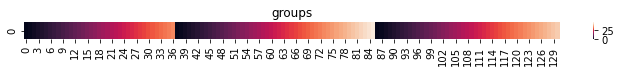

In [8]:
groups=np.zeros(len(X), dtype=int)
site = []
clr = np.zeros(len(X), dtype=float)
g=0
i=0
while i < np_s1:
    groups[i] = g
    s_name = 'study 1'
    site.append(s_name)
    #groups[i+1] = g
    clr[i] = 0.1
    i += 1
    g += 1
  

g=0
i=np_s1
while i < np_s1+np_s2:
    groups[i] = g
    s_name = 'study 2'
    site.append(s_name)
    clr[i] = 0.5
    #groups[i+1] = g
    i += 1
    g += 1


g=0
i=np_s1+np_s2
while i < len(X):
    groups[i] = g
    s_name = 'study 3'
    site.append(s_name)
    clr[i] = 0.8
    i += 1
    g += 1
    

plt.figure(figsize=(12, 0.3))
sns.heatmap([groups]).set_title('groups')
plt.show() 
groups  
sites = pd.DataFrame(site)
sites.columns = ['centre']
sites.index = covariates.index
clrs = pd.DataFrame(clr)
clrs.columns = ['centre']
clrs.index = sites.index

In [9]:
np_s3

45

# do not Regress out eTIV

In [10]:
X_feature = pd.concat([X_lhcorticalthickness.div(covariates['mThickness'],axis=0),
                       X_rhcorticalthickness.div(covariates['mThickness'],axis=0)],axis=1)
y=target['QST']
X_feature['eTIV'] = covariates['eTIV'].div(1000000)
X_norm = X_feature
X_norm.head(2)

,lh_bankssts_thickness,lh_caudalanteriorcingulate_thickness,lh_caudalmiddlefrontal_thickness,lh_cuneus_thickness,lh_entorhinal_thickness,lh_fusiform_thickness,lh_inferiorparietal_thickness,lh_inferiortemporal_thickness,lh_isthmuscingulate_thickness,lh_lateraloccipital_thickness,...,rh_rostralmiddlefrontal_thickness,rh_superiorfrontal_thickness,rh_superiorparietal_thickness,rh_superiortemporal_thickness,rh_supramarginal_thickness,rh_frontalpole_thickness,rh_temporalpole_thickness,rh_transversetemporal_thickness,rh_insula_thickness,eTIV
sub-004_T1w_s1,1.022095,1.085502,1.007340,0.814326,1.414503,1.103847,0.981817,1.101454,0.926386,0.882120,...,0.927582,1.105043,0.845033,1.166855,1.032463,1.082711,1.439228,0.981020,1.245815,1.563487
sub-005_T1w_s1,0.970548,1.036479,1.019689,0.750229,1.159334,1.043441,0.995119,1.060231,0.939425,0.913625,...,0.963996,1.155239,0.889874,1.117154,1.009861,1.020099,1.235913,0.974643,1.117154,1.777286


In [11]:
covariates.head()

,Age,sex,batch,eTIV,mThickness
sub-004_T1w_s1,25.552361,1.0,1.0,1.563487e+06,2.507595
sub-005_T1w_s1,23.800137,1.0,1.0,1.777286e+06,2.441920
sub-006_T1w_s1,33.453799,1.0,1.0,1.581288e+06,2.492065
sub-007_T1w_s1,26.119097,1.0,1.0,1.648965e+06,2.489610
sub-008_T1w_s1,25.445585,1.0,1.0,1.584414e+06,2.546875


# Machine learning

In [12]:
model_try = 'modelLasso_nf'
model_steps = 'model_Lasso'
feature_size = np.size(X_norm, 1)
print('feature size =' + str(feature_size))
model_get = models_ml(model_try, feature_size)
model, p_grid = model_get.get_model()
cov = np.array(covariates)

feature size =69


In [13]:
np.arange(0,np.size(X_feature,1),1)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68])

In [14]:
col_names  = X_feature.columns[0:68]

In [15]:
outer_cv = LeavePGroupsOut(1)
inner_cv = GroupKFold(10)                                    
clf = GridSearchCV(estimator=model, param_grid=p_grid, cv=inner_cv,
                   scoring="neg_mean_squared_error", verbose=True, return_train_score=False,
                   n_jobs=-1)
results_cv = []
all_models = []
best_params = []
predicted = np.zeros(len(y))
pred_test = np.zeros(len(y))
#nested_scores_train = np.zeros(outer_cv.get_n_splits(X_norm, groups = groups))
#nested_scores_test = np.zeros(outer_cv.get_n_splits(X_norm, groups = groups ))   
                                    
#print("model\tinner_cv mean score\touter vc score")
i=0
for train, test in outer_cv.split(X_norm, y, groups=covariates.batch.values):
#for train, test in outer_cv.split(X_norm, y):
    group_train = groups[train]  
    
    #########################################################################################
    # use comabt 
    comb = CombatModel()
    X_train_combat = comb.fit_transform(X_norm.iloc[train],
                                   np.array([covariates.batch.values[train]]).transpose(),
                                   np.array([covariates.sex.values[train]]).transpose(),
                                   np.array([covariates.Age.values[train]]).transpose()
                                       )
    
    #########################################################################################                                    
    # 1. fit LASSO on combat model without TIV as a feature, ind = 68                                    
    #clf.fit(X_train_combat[:,0:68], y[train])
    clf.fit(X_train_combat[:,0:68], y[train], groups=group_train)
    # 2. predict same training data with the best estimator
    pred_train = clf.predict(X_train_combat[:,0:68])
    # 3. use training data and batch corrected TIV to fit a linear regression model
    lr = LinearRegression()
    lr.fit(pd.DataFrame(X_train_combat[:,68]),pred_train)

    
    #########################################################################################
    #use combat
    print (int(covariates.batch.values[train][0]), int(covariates.batch.values[train][-1]))
    if (int(covariates.batch.values[train][0]) == 1) and (int(covariates.batch.values[train][-1]) == 2):
        temp_batch = [np.full(len(test), 1),np.full(len(test), 2)]
        df_temp_batch = pd.DataFrame(temp_batch)
        
    if (int(covariates.batch.values[train][0]) == 1) and (int(covariates.batch.values[train][-1]) == 3):
        temp_batch = [np.full(len(test), 1),np.full(len(test), 3)]
        df_temp_batch = pd.DataFrame(temp_batch) 
    
    if (int(covariates.batch.values[train][0]) == 2) and (int(covariates.batch.values[train][-1]) == 3):
        temp_batch = [np.full(len(test), 2),np.full(len(test), 3)]
        df_temp_batch = pd.DataFrame(temp_batch)        

    df_temp_batch_trans = df_temp_batch.T
    df_temp_batch_trans.columns = ['batch1', 'batch2'] 
    print(df_temp_batch_trans)
    X_test_combat = comb.transform(X_norm.iloc[test],
                                   np.array([df_temp_batch_trans.batch1.values]).transpose(),
                                   np.array([covariates.sex.values[test]]).transpose(),
                                   np.array([covariates.Age.values[test]]).transpose()
                                  )
    #                           
    #########################################################################################
    #print('cv:', i, str(clf.best_params_) + " " + str(clf.best_score_) + " " + str(clf.score(X_test_combat, y[test])))
    #all_models.append(clf.best_estimator_)
    #best_params.append(clf.best_params_)
    print(test)
    # 4. use batch corrected test data to predict with LASSO
    pred_test[test] = clf.predict(X_test_combat[:,0:68])
    # 5. use batch corrected TIV to predict test features.
    pred_test_using_tiv = lr.predict(pd.DataFrame(X_test_combat[:,68]))
    # 6. consider residuals as final predicted QST from test
    predicted[test] = pred_test[test] - pred_test_using_tiv
                                    
    #ested_scores_train[i] = clf.best_score_
    #nested_scores_test[i] = clf.score(X_test_combat[:,0:68], y[test])
    i = i+1
    
    weights=clf.best_estimator_.named_steps[model_steps].coef_
    weights_idx = np.nonzero(weights)
    res = pd.DataFrame([weights[weights_idx], X_feature.columns[weights_idx]])
    main = res.T.sort_values(by=0)
    print(main)
    print(clf.best_params_)
    print(weights)
    #weights_res = weights.flatten()
    #results_cv.append(weights_res)
    
    #df_results_res = pd.DataFrame(results_cv)
    #df_results_res.columns = col_names

    #df_results_res.to_csv('nested_cv_results_batch1.csv')
    #new = df_results_res.loc[:, (df_results_res != 0).any(axis=0)]
    #new_mean = new.mean(axis = 0)
    #new_mean.to_csv('resultsNestedCV')
    #print(new_mean.sort_values(ascending=False))
    #print("*** Score on mean as model:\t" + str(-mean_squared_error(np.repeat(y.mean(), len(y)), y)))
    #print("** Mean score in the inner crossvaludation (inner_cv):\t" + str(nested_scores_train.mean()))
    #print("** Mean Nested Crossvalidation Score (outer_cv):\t" + str(nested_scores_test.mean()))
    #print("Explained Variance: " +  str( 1- nested_scores_test.mean()/-mean_squared_error(np.repeat(y.mean(), len(y)), y) ))
    #print("Correlation: " + str(np.corrcoef(y, predicted)[0,1]))
                                    
p_corr = permutation_test(predicted, y,
                           func=lambda x, y: np.corrcoef(x, y)[0,1],
                           method='approximate',
                           num_rounds=10000,
                           seed=42)
print('nested pearson r = ' + str(np.corrcoef(predicted, y)[0,1]) + ' permutation p =' + str(round(p_corr,4)) )


Fitting 10 folds for each of 17 candidates, totalling 170 fits
2 3
    batch1  batch2
0        2       3
1        2       3
2        2       3
3        2       3
4        2       3
5        2       3
6        2       3
7        2       3
8        2       3
9        2       3
10       2       3
11       2       3
12       2       3
13       2       3
14       2       3
15       2       3
16       2       3
17       2       3
18       2       3
19       2       3
20       2       3
21       2       3
22       2       3
23       2       3
24       2       3
25       2       3
26       2       3
27       2       3
28       2       3
29       2       3
30       2       3
31       2       3
32       2       3
33       2       3
34       2       3
35       2       3
36       2       3
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36]
          0                                      1
1  -1.72092  rh_rostralanteriorcingulate_thick

# Figure 2 part 2: study-wise predictions

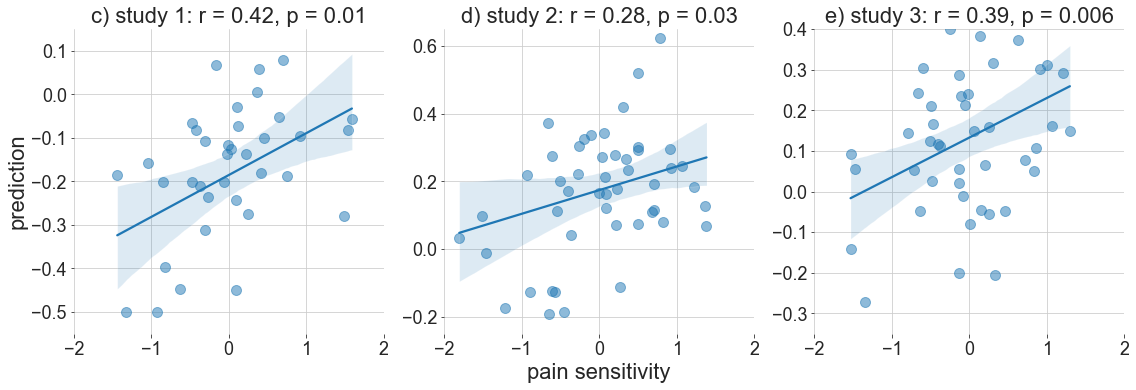

In [16]:
sns.set_style('ticks')
fig, axs = plt.subplots(ncols=3, figsize=(16,6), sharex=False, sharey=False)

##########################################################################################################
col=0
data = pd.DataFrame(y)
predicted = pd.DataFrame(predicted)
predicted.index = data.index
predicted.columns = ['predicted']
data = pd.concat([data, predicted,sites],axis=1)
data_s1 = data.iloc[0:np_s1,:]
g=sns.regplot(x='QST', y='predicted',data=data_s1,scatter=True, ax =axs[col], color ='tab:blue', scatter_kws={'alpha':0.5, 's':100})
axs[col].tick_params(axis='x', which='major', labelsize=18)
axs[col].tick_params(axis='y', which='major', labelsize=18)
#plt.suptitle('Out-of-center generalization predictions', fontsize= 24, fontweight = "bold")
axs[col].set_xlabel('')
axs[col].set_ylabel('prediction', fontsize = 22)
axs[col].spines['top'].set_visible(False)
axs[col].spines['bottom'].set_visible(False)
axs[col].spines['right'].set_visible(False)
axs[col].spines['left'].set_visible(False)
axs[col].set_xlim([-2, 2])
axs[col].set_ylim([-.55, .15])
axs[col].grid(True)
c_temp=round(np.corrcoef(data_s1['QST'], data_s1['predicted'])[0,1],2)
p_temp =round(permutation_test(data_s1['QST'],data_s1['predicted'],
                           func=lambda x, y: np.corrcoef(x, y)[0,1],
                           method='approximate',
                           num_rounds=10000,
                           seed=42),2 )
axs[col].set_title('c) study 1: ' + 'r = ' + str(c_temp) + ', p = ' + str(p_temp), fontsize=22)
##########################################################################################################

col=1
data = pd.DataFrame(y)
predicted = pd.DataFrame(predicted)
predicted.index = data.index
predicted.columns = ['predicted']
data = pd.concat([data, predicted,sites],axis=1)
data_s2 = data.iloc[np_s1:np_s1+np_s2,:]
g=sns.regplot(x='QST', y='predicted',data=data_s2,scatter=True, ax =axs[col],color ='tab:blue', scatter_kws={'alpha':0.5, 's':100} )
axs[col].tick_params(axis='x', which='major', labelsize=18)
axs[col].tick_params(axis='y', which='major', labelsize=18)
axs[col].set_xlabel('pain sensitivity', fontsize = 22)
axs[col].set_ylabel('')
axs[col].spines['top'].set_visible(False)
axs[col].spines['bottom'].set_visible(False)
axs[col].spines['right'].set_visible(False)
axs[col].spines['left'].set_visible(False)
axs[col].set_xlim([-2, 2])
axs[col].set_ylim([-.25, .65])
axs[col].grid(True)
c_temp=round(np.corrcoef(data_s2['QST'], data_s2['predicted'])[0,1],2)
p_temp =round(permutation_test(data_s2['QST'],data_s2['predicted'],
                           func=lambda x, y: np.corrcoef(x, y)[0,1],
                           method='approximate',
                           num_rounds=10000,
                           seed=42),2 )
axs[col].set_title('d) study 2: ' + 'r = ' + str(c_temp) + ', p = ' + str(p_temp) , fontsize=22 )

##########################################################################################################

col=2
data = pd.DataFrame(y)
predicted = pd.DataFrame(predicted)
predicted.index = data.index
predicted.columns = ['predicted']
data = pd.concat([data, predicted,sites],axis=1)
data_s3 = data.iloc[np_s1+np_s2:np_s1+np_s2+np_s3]
g=sns.regplot(x='QST', y='predicted',data=data_s3,scatter=True, ax =axs[col], color ='tab:blue', scatter_kws={'alpha':0.5, 's':100})
axs[col].tick_params(axis='x', which='major', labelsize=18)
axs[col].tick_params(axis='y', which='major', labelsize=18)
axs[col].spines['top'].set_visible(False)
axs[col].spines['bottom'].set_visible(False)
axs[col].spines['right'].set_visible(False)
axs[col].spines['left'].set_visible(False)
axs[col].set_xlim([-2, 2])
axs[col].set_ylim([-.35, .4])
axs[col].grid(True)
axs[col].set_xlabel('')
axs[col].set_ylabel('')
c_temp=round(np.corrcoef(data_s3['QST'], data_s3['predicted'])[0,1],2)
p_temp =round(permutation_test(data_s3['QST'],data_s3['predicted'],
                           func=lambda x, y: np.corrcoef(x, y)[0,1],
                           method='approximate',
                           num_rounds=10000,
                           seed=42),3)
axs[col].set_title('e) study 3: ' + 'r = ' + str(c_temp) + ', p = ' + str(p_temp) , fontsize=22 )
plt.tight_layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("../output/manuscript_f1-c-e.jpg", dpi=1200, bbox_inches = 'tight')
